<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/pytorch_2_dim_moon_nice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torch import nn
from sklearn import datasets
from torch.utils.data import DataLoader

In [83]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, sample_size=1000):
        super(Datasets, self).__init__()

        self.uniform = torch.distributions.Uniform(low=torch.tensor([0., 0.]), high=torch.tensor([1., 1.]))
        self.x_uniform = self.uniform .sample([sample_size])

        self.length = sample_size

    def __len__(self):
            return self.length

    def __getitem__(self, idx):
        x = self.x_uniform[idx, :]
        return x

In [84]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                nn.BatchNorm1d(self.hidden_layer),
                                nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                nn.BatchNorm1d(self.hidden_layer),
                                nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                nn.BatchNorm1d(self.hidden_layer),
                                nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                nn.BatchNorm1d(self.hidden_layer),
                                nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(input_dim))


    def forward(self, x):
        return self.f(x)

    def coupling_layer(self, x, m, forward=True):

        x_a = x[:, 0].reshape((-1,1))
        x_b = x[:, 1].reshape((-1,1))

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        z = torch.concat((x_a, y_b), axis=1)

        return z


    def f(self, x):
        z = x

        for model in self.m:
            z = self.coupling_layer(z, model, forward=True)

        z = z * torch.exp(-self.s)
        log_det_j = torch.sum(self.s)      # eksi olabilir başında

        return z, log_det_j

    def f_inv(self, z):
        x = z * torch.exp(self.s)

        for model in reversed(self.m):
            x = self.coupling_layer(x, model, forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) - log_det_j).sum()
        else:

            loss = - (prior.log_prob(z).sum(dim=1) - log_det_j).mean()
        return loss

In [85]:
#x = Datasets(sample_size=1000)
prior = torch.distributions.Normal(loc=torch.tensor([0., 0.]), scale=torch.tensor([1., 1.]))

model = NICE(input_dim=2, hidden_layer=64, num_flows=4)


In [86]:
X,y = datasets.make_moons(n_samples=10000, shuffle=True, noise=0.01, random_state=1234)
x = torch.tensor(X, dtype=torch.float32)

train_loader = DataLoader(x, batch_size=2000)

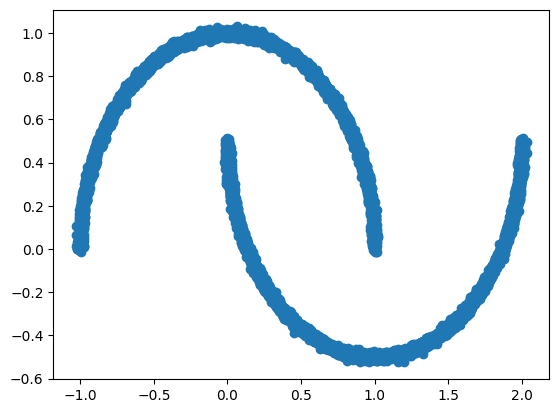

In [87]:
plt.scatter(x[:][:,0], x[:][:,1])

In [88]:
epochs = 2000
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%100 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  3.9864506244659426
Epoch :  100   -----------> Loss :  1.7848178625106812
Epoch :  200   -----------> Loss :  1.776831078529358
Epoch :  300   -----------> Loss :  1.7728100299835206
Epoch :  400   -----------> Loss :  1.7728861093521118
Epoch :  500   -----------> Loss :  1.7726568222045898
Epoch :  600   -----------> Loss :  1.7776190996170045
Epoch :  700   -----------> Loss :  1.773422908782959
Epoch :  800   -----------> Loss :  1.790660309791565
Epoch :  900   -----------> Loss :  1.7732964515686036
Epoch :  1000   -----------> Loss :  1.7757040023803712
Epoch :  1100   -----------> Loss :  1.7716081619262696
Epoch :  1200   -----------> Loss :  1.7693813562393188
Epoch :  1300   -----------> Loss :  1.7691608667373657
Epoch :  1400   -----------> Loss :  1.7684772729873657
Epoch :  1500   -----------> Loss :  1.771978497505188
Epoch :  1600   -----------> Loss :  1.7699269771575927
Epoch :  1700   -----------> Loss :  1.7671096324920654
Epoch : 

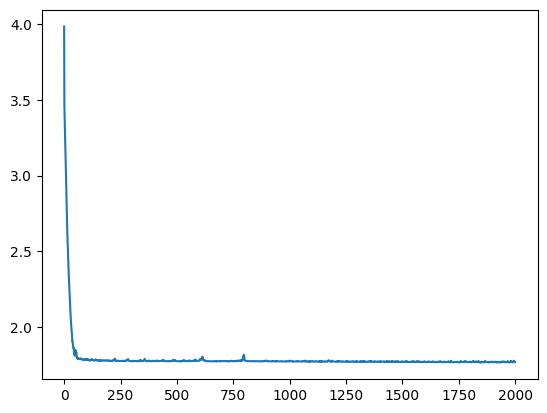

In [89]:
plt.plot(COST)

In [90]:
test = prior.sample((10000,))
test

tensor([[ 0.8492,  1.3297],
        [-1.0705, -0.6604],
        [-0.6417,  0.4142],
        ...,
        [ 0.3667, -0.8241],
        [ 1.3175, -0.6012],
        [ 1.2486,  0.8021]])

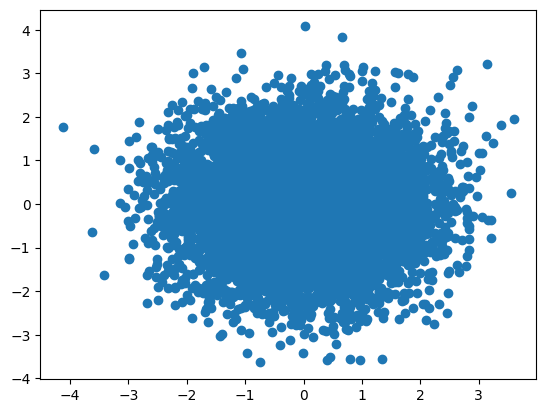

In [91]:
plt.scatter(test[:,0], test[:,1])

In [92]:
sonuc = model.f_inv(test)
sonuc

tensor([[ 0.8498,  0.3811],
        [-1.0712,  0.4817],
        [-0.6422,  0.8623],
        ...,
        [ 0.3669,  0.0371],
        [ 1.3183, -0.7267],
        [ 1.2494, -0.2792]], grad_fn=<CatBackward0>)

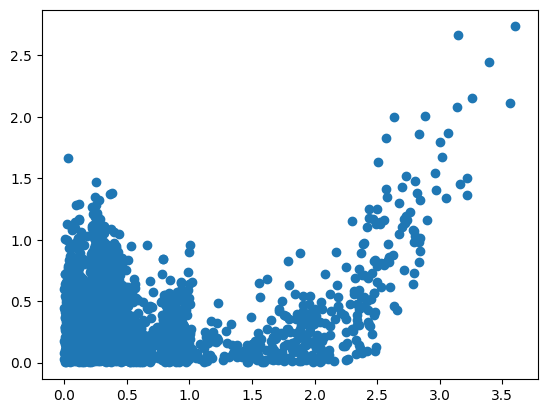

In [93]:
a = sonuc.detach().numpy()[sonuc.detach().numpy()[:,0]>0]
b = a[a[:,1]>0]
plt.scatter(b[:,0], b[:,1])

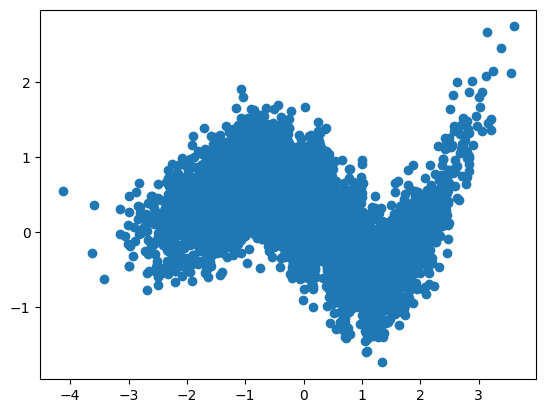

In [94]:
plt.scatter(sonuc[:,0].detach().numpy(), sonuc[:,1].detach().numpy())